[array([[ 1.57175348, -1.71088532, -2.18518837,  0.41051815,  1.75575176,
        -0.61514832,  3.84611359,  1.47863791, -0.15254479, -0.86305985],
       [-1.25457587,  1.83239766, -0.49142204, -3.52257683, -0.81564596,
         1.90396325, -2.54006616, -2.59638595,  0.25241099,  0.2546207 ],
       [ 1.07520767,  2.79545435,  1.7956426 ,  0.88818809,  1.77954706,
        -1.41632869, -1.10569076, -2.17389415, -1.65028763,  1.04780899]]), array([[-3.26316048],
       [-0.53039062],
       [-0.55309789],
       [-0.05051922],
       [-0.59335768],
       [-1.50191022],
       [-0.58918954],
       [ 3.1471133 ],
       [ 3.55328015],
       [ 0.01469341]])]
New best model found
0 epoch, train_err: 0.1605, valid_err: 0.1081
New best model found
1 epoch, train_err: 0.1019, valid_err: 0.0937
2 epoch, train_err: 0.0887, valid_err: 0.0986
3 epoch, train_err: 0.0803, valid_err: 0.1010
New best model found
4 epoch, train_err: 0.0871, valid_err: 0.0863
5 epoch, train_err: 0.0779, valid_err: 0.

76 epoch, train_err: 0.0385, valid_err: 0.0266
77 epoch, train_err: 0.0407, valid_err: 0.0349
78 epoch, train_err: 0.0416, valid_err: 0.0311
79 epoch, train_err: 0.0408, valid_err: 0.0345
[array([[  1.87123178e+00,  -1.47919758e+00,  -2.45795800e+00,
         -2.43731786e+00,   3.86177862e-05,   1.67036261e+00,
          1.82744026e+00,   2.94554588e+00,  -1.83552511e+00,
         -3.98419792e-02],
       [ -2.91645760e+00,   8.78489017e-01,  -2.34931276e+00,
         -2.02848360e+00,  -1.08245187e-01,   1.80054628e+00,
         -1.15399705e+00,  -1.81659834e+00,   2.88360405e+00,
          7.06893326e-05],
       [  2.77733889e+00,   9.75082633e-01,   2.70902960e+00,
         -2.28351528e+00,  -1.16829503e-01,  -2.28405867e+00,
         -1.61579366e+00,  -2.35266079e+00,  -2.79466861e+00,
         -1.12319788e-01]]), array([[ -3.85470408e+00],
       [ -1.30726388e+00],
       [  4.07045318e+00],
       [ -4.23538594e+00],
       [ -3.11889556e-03],
       [ -2.35098497e+00],
       [

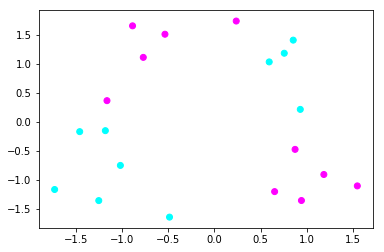

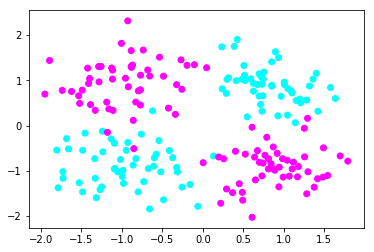

In [173]:
### DL gyak, 2017.09.21.

#NEPTUNKOD=TQNX0O

import numpy as np
import matplotlib.pyplot as plt
import copy
import random
### %matplotlib inline
def activation(x):
    return 1/(1+np.exp(-x))
    
def dactivation(x):
    return np.exp(-x)/((1+np.exp(-x))**2)
    
segedX = np.linspace(-6,6,200)
#print(segedX)

#%% (2,3,1)
class MLP:
    def __init__(self,*args):
        np.random.seed(123)
        self.shape = args
        n = len(args)
        self.layers = [] # retegek
        # bemenetek
        self.layers.append(np.ones(self.shape[0]+1))
        # rejtett retegek es a kimenet letrehozasa
        for i in range(1,n):
            self.layers.append(np.ones(self.shape[i]))
        # sulymatrixok
        self.weights = []
        
        for i in range(n-1):
            self.weights.append(np.zeros((self.layers[i].size,
                                         self.layers[i+1].size)))
        
        # HF2 start minibatch
        self.accumu = []
        for i in range(n-1):
            self.accumu.append(np.zeros((self.layers[i].size,
                                         self.layers[i+1].size)))
        # HF2 end minibatch
        
        # HF2 start dropout
        self.dropout = []
        # HF2 end dropout
        
        # ....
        self.dw = [0,]*len(self.weights)
        self.reset()
        
    def reset(self):
        for i in range(len(self.weights)):
            z = np.random.random((self.layers[i].size,self.layers[i+1].size))
            self.weights[i] = (2*z-1)*4 # -4..4 
        
    def propagate_forward(self, data):
        self.layers[0][0:-1] = data
        # azt akarjuk kiszamolni, amit a-val jeloltunk
        for i in range(1,len(self.shape)):
            # HF2 start dropout
            self.layers[i] = activation( np.dot( self.layers[i-1]*self.dropout[i-1] , self.weights[i-1] ) )
            #maszkoljuk a retegeket a dropout tombokkel
            # HF2 end dropout
        
        return self.layers[-1] # y_kalap
        
    def propagate_backward(self, target, lr, momentum, lam1, lam2):
        deltas=[]
        error = -(target-self.layers[-1]) # -(y-y_kalap)
        # error*dactivation(s(3))
        delta = np.multiply(error,dactivation(np.dot(self.layers[-2], self.weights[-1])))
        deltas.append(delta)
        # gradiens kiszamitasa a rejtett retegekben
        for i in range(len(self.shape)-2,0,-1):
            # pl. delta(3)*(W(2).T)*dactivation(s(2))
            
            # HF2 start dropout
            delta = np.dot(deltas[0], self.weights[i].T) * \
                            dactivation( np.dot (self.layers[i-1]*self.dropout[i-1], self.weights[i-1]))
            #backpropnal is a maszkoljuk a retegeket a dropout tombokkel
            # HF2 end dropout
            deltas.insert(0,delta)
        # sulyok modositasa
        for i in range(len(self.weights)):
            layer = np.atleast_2d(self.layers[i])
            delta = np.atleast_2d(deltas[i])
            dw = np.dot(layer.T,delta)
            
            # HF2 start minibatch
            #akkumulaljuk a sulyfrissiteseket, csak kulon hivasra hatnak a sulyokra
            
            # HF2 start l2reg
            self.accumu[i] -= lr*lam2*self.weights[i]
            # HF2 end l2reg
            
            # HF2 start l1reg
            self.accumu[i] -= lr*lam1*np.sign(self.weights[i])
            # HF2 end l1reg
            
            #self.accumu[i] += -lr*dw+self.dw[i]*momentum
            
            # HF2 start l1reg
            self.accumu[i] += -1*(1+momentum)*lr*dw+self.dw[i]*momentum*momentum
            # HF2 end nesterov
            
            # HF2 end minibatch
            
            self.dw[i] = dw
            
        return (error**2).sum()
    
    # HF2 start minibatch
    #az akkumulalt sulyfrisiteseket leosztjuk a batch meretevel, majd a sulyhoz adjuk
    def update_weights(self, n):
        for i in range(len(self.weights)):
            self.weights[i] += self.accumu[i]/n
        self.accumu = []
        for i in range(len(self.shape)-1):
            self.accumu.append(np.zeros((self.layers[i].size,
                                         self.layers[i+1].size)))
    # HF2 end minibatch
    
    # HF2 start dropout
    def generate_dropout(self, ratio):
        self.dropout = []
        
        self.dropout.append(np.ones(self.layers[0].shape))
        for i in range(1,len(self.shape)-1):
          
            self.dropout.append(np.zeros(self.layers[i].shape))
            for j in range(0, self.layers[i].shape[0]):
                if random.uniform(0, 1) > ratio:
                    self.dropout[i][j] = 1
        self.dropout.append(np.ones(self.layers[-1].shape))
    # HF2 end dropout
#%%
# valid_split: 0.1---> 10% validacios adat
# test_split: 0.2 ---> 20% teszt adat
# 70% train
def learn(network, samples, valid_split, test_split, epochs=10000, lr=0.01, momentum=0.1, patience=20, lam1=0, lam2=0, batch=1, dropout=0):
    
    samples_train = samples[0:int(nb_samples*(1-valid_split-test_split))]
    samples_valid = samples[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
    samples_test  = samples[int(nb_samples*(1-test_split)):]
    
    from sklearn import preprocessing
    
    # standardizalas
    scaler = preprocessing.StandardScaler().fit(samples_train['input'])
    samples_train['input'] = scaler.transform(samples_train['input'])
    samples_valid['input'] = scaler.transform(samples_valid['input'])
    samples_test['input'] = scaler.transform(samples_test['input'])    
    
    # kevers
    np.random.shuffle(samples_train)
    np.random.shuffle(samples_valid)
    np.random.shuffle(samples_test)
    
    best_valid_err = np.inf
    es_counter = 0
    best_model = network
    
    # tanitasi fazis
    for i in range(epochs):        
        train_err = 0
        
        if i%10 == 0:
            print(network.weights)
        
        # HF2 start minibatch
        np.random.shuffle(samples_train)
        #minden epoch elott masok legyenek a batchok
        # HF2 end minibatch
        
        # HF2 start dropout
        network.generate_dropout(dropout)
        # HF2 end dropout
        for k in range(0,samples_train.size,batch):
            # HF2 start minibatch
            for j in range(0,batch):
                network.propagate_forward( samples_train['input'][k+j] )
                train_err += network.propagate_backward( samples_train['output'][k+j], lr, momentum, lam1, lam2 )
            network.update_weights(batch)
            # HF2 end minibatch
        train_err /= samples_train.size
        
        # validacio
        valid_err = 0
        o_valid = np.zeros(samples_valid.size)
        for k in range(samples_valid.size):
            o_valid[k] = network.propagate_forward(samples_valid['input'][k])
            valid_err += (o_valid[k]-samples_valid['output'][k])**2
        valid_err /= samples_valid.size
        
        # Early stoping kesobb vagy HF
        if np.round(valid_err,3) < np.round(best_valid_err,3):
            best_valid_err = np.round(valid_err,3)
            es_counter = 0
            best_model = copy.copy(network)
            print("New best model found")
        else:
            es_counter += 1
            
        print("%d epoch, train_err: %.4f, valid_err: %.4f" % (i, train_err, valid_err))
        
        if es_counter > patience:
            print("Early stoping, loading back best model")
            print(network.weights)
            network=best_model
            break
        
  
    test_err = 0
    o_test = np.zeros(samples_test.size)
    for k in range(samples_test.size):
        o_test[k] = network.propagate_forward(samples_test['input'][k])
        test_err += (o_test[k]-samples_test['output'][k])**2
        #print(k, samples_test['input'][k], '%.2f' % o_test[k], \
        #      ' (elvart eredmeny: %.2f)' % samples_test['output'][k])
    test_err /= samples_test.size
    print(test_err)
    fig1=plt.figure()
    plt.scatter(samples_test['input'][:,0], samples_test['input'][:,1], c=np.round(o_test[:]), cmap=plt.cm.cool)
    
network = MLP(2,10,1)
nb_samples=200
samples=np.zeros(nb_samples, dtype=[('input', float, 2), ('output', float, 1)])
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    samples[i] = (-2+noise[0],-2+noise[1]), 0
    samples[i+1] = (2+noise[2],-2+noise[3]), 1
    samples[i+2] = (-2+noise[4],2+noise[5]), 1
    samples[i+3] = (2+noise[6],2+noise[7]), 0
    
#az elsonel kisebbek a sulyok
learn(network, samples, 0.2, 0.1, momentum=0.1, lr=1, lam1=0.0001, lam2=0.0001, batch=1, dropout=0.0)
#learn(network, samples, 0.2, 0.1, momentum=0.1, lr=1, lam1=0.0, lam2=0.0, batch=1, dropout=0.0)
    


fig1=plt.figure()
plt.scatter(samples['input'][:,0],samples['input'][:,1],c=samples['output'][:], cmap=plt.cm.cool)

plt.show()